# Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

Импорт необходимых модулей.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print('Размер выборки:', len(labels))

Размер выборки: 7591


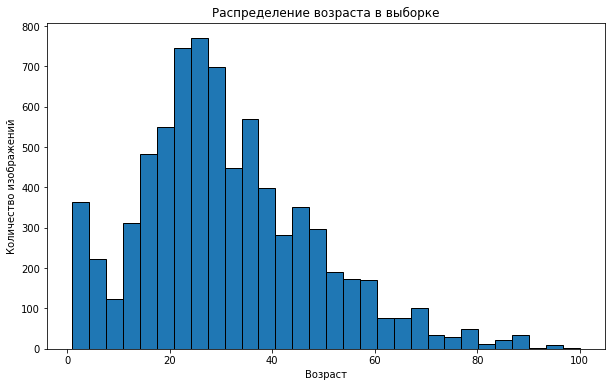

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, edgecolor='k')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.title('Распределение возраста в выборке')
plt.show()

В выборке больше всего фотографий людей в возрасте от 20 до 30 лет.

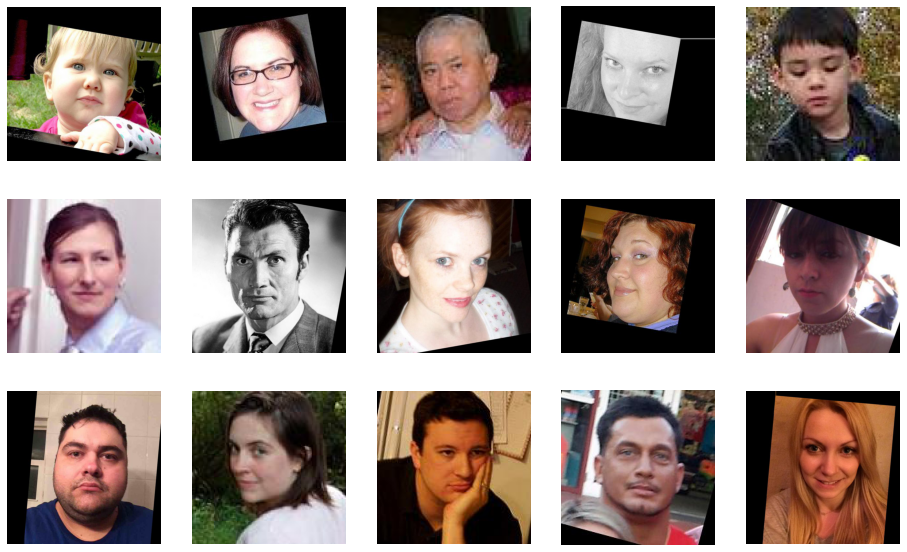

In [4]:
def show_images(path, df, num_images):
    plt.figure(figsize=(16, 10))
    for i in range(num_images):
        random_image = random.choice(df['file_name'])
        img_path = path + '/final_files/' + random_image
        img = Image.open(img_path)
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.show()

show_images('/datasets/faces/', labels, num_images=15)

1. Размер выборки составляет 7591 изображение, что достаточно большой объем данных.
2. Фотографии в датасете имеют разное качество и освещение, а также различные позы и выражения лиц, что может усложнить обучение модели.
3. Некоторые фотографии могут содержать людей другого возраста (например, детей или пожилых людей), что может затруднить точное определение возраста.

# Создание модели

In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

# Результаты обучения модели

# Вывод

1. При обучении модели на эпохе 1 метрика MAE для обучающего набора составила 11.13, а для валидационного набора - 25.65. Это может указывать на переобучение модели, поскольку метрика MAE для валидационного набора заметно выше, чем для обучающего набора. 

2. В дальнейших эпохах метрика MAE как для обучающего, так и для валидационного набора снижается, что говорит о продвижении модели в правильном направлении. В результате на последней эпохе модель достигает MAE 6.60 для валидационного набора и 4.08 для обучающего набора.

3. Метрика потерь (loss) также снижается с каждой эпохой, что дополнительно подтверждает, что модель находится в процессе обучения.

4. Время, затраченное для каждой эпохи, варьируется от 38 до 46 секунд.

В целом, модель показывает улучшение с каждой эпохой, и на последней эпохе достигает MAE 6.60 для валидационного набора. Однако, возможно, модель все еще недостаточно точна и может быть улучшена путем дальнейшего обучения или изменения параметров модели.